In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders.hashing import HashingEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Load dataset
items = pd.read_csv("../data/preprocessed/items_merged.txt")

In [3]:
# Define predictors and target variable
X = items.drop(['sold_quantity'], axis=1)
y = items["sold_quantity"]

In [4]:
def retrieve_categorical(dataframe):
    """Returns a list containing the categorical features of
    the given dataframe."""
    columns = list(dataframe.columns)
    numerical_columns = list(dataframe._get_numeric_data().columns)
    categorical_columns = list(set(columns) - set(numerical_columns))
    categorical_columns.sort()
    return categorical_columns

In [5]:
# Remove categorical columns with very high cardinality or with only
# one value
categorical = retrieve_categorical(X)
for column in categorical:
    if len(X[column].unique()) > 0.5*X.shape[0] or \
        len(X[column].unique()) == 1:
        X = X.drop(columns=column)

In [6]:
# Identify similar categorical columns and group them in lists
categorical = retrieve_categorical(X)

category_columns = [column for column in retrieve_categorical(X) 
                    if "category" in column or "catalog" in column
                   ]

date_columns = [column for column in retrieve_categorical(X) 
                if "date" in column 
                or ("time" in column and "reputation" not in column)
                or "last_updated" in column
               ]

location_columns = [column for column in retrieve_categorical(X) 
                    if "address" in column]

eshop_columns = [column for column in retrieve_categorical(X) 
                 if "eshop" in column]

reputation_columns = [column for column in retrieve_categorical(X) 
                      if "reputation" in column]

shipping_columns = [column for column in retrieve_categorical(X) 
                    if "shipping" in column]

In [7]:
# Process date columns   
for column in date_columns:
    X[column] = pd.to_datetime(X[column])
    X[column+"_day"] = X[column].dt.day
    X[column+"_month"] = X[column].dt.month
    X[column+"_year"] = X[column].dt.year

X = X.drop(columns=date_columns)

In [8]:
# Process rest of grouped categorical features
column_groups = {
    "category": category_columns,
    "location": location_columns,
    "eshop": eshop_columns,
    "reputation": reputation_columns,
    "shipping": shipping_columns
}

column_groups_names = list(column_groups.keys())
# Hashing encoding has been selected due to high cardinality
# features.
for group in column_groups_names:
    data = HashingEncoder(
        cols=column_groups[group],
    ).fit_transform(X, y)
    
    new_names = {}
    for loc in range(8):
        new_names["col_"+str(loc)] = group+"_"+str(loc)
    
    X = data.rename(columns = new_names)      

C:\Users\tomas\anaconda3\envs\meli\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
# Hand-picked selection of features from the remaining categorical variables:
# 1) buying_mode
# 2) condition
# 3) listing_type_id
remaining_categorical = [
    "buying_mode", 
    "condition", 
    "listing_type_id"
]

columns_to_eliminate = list(
    set(retrieve_categorical(X)) \
    - set(remaining_categorical)
)

X = X.drop(columns_to_eliminate, axis=1) 

In [10]:
# Apply one hot encoding to the remaining categorical features
# (low cardinality)
for column in remaining_categorical:
    aux = pd.get_dummies(X[column], prefix=column)
    pd.concat([X, aux], axis=1)#
    
X = X.drop(remaining_categorical, axis=1)

In [11]:
# Nulls imputation in original price
for index in X.index:
    if pd.isnull(X.original_price[index]): X.original_price[index] = X.price[index]

C:\Users\tomas\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# Nulls imputation in rest of features
for column in X.columns:
    if X[column].isnull().sum() > 0: X[column].fillna(X[column].mean(), inplace = True)

In [13]:
# Define simple decision tree model to assess feature importance
model = DecisionTreeRegressor()

# Fit the model
model.fit(X, y)

# Importance coefficients
importance_coef = model.feature_importances_

# Sort features by importance value
importance_df = pd.DataFrame(index=X.columns, data=importance_coef).reset_index() 
importance_df.columns = ["feature", "importance"]
importance_df = importance_df.sort_values("importance", ascending=False)

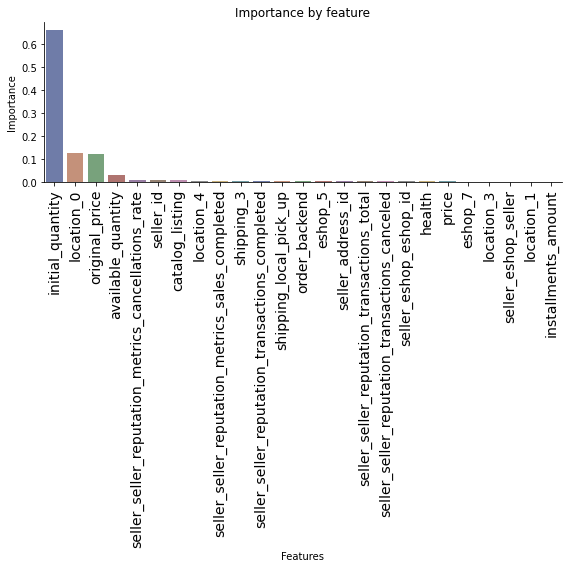

In [14]:
# Visualize importance coefficients
chart = sns.catplot(
    data=importance_df.iloc[0:25], kind="bar",
    x="feature", y="importance",
    ci="sd", palette="dark", alpha=.6, height=8
)
chart.set_xticklabels(importance_df.feature.iloc[0:25], fontsize=14, rotation=90)
chart.set(xlabel ="Features", ylabel = "Importance", title ='Importance by feature')

plt.tight_layout()
plt.savefig('../images/feature_importance.png')

![title](../images/feature_importance.png)

In [15]:
# Top 25 features by importance remain in dataset
features = list(importance_df.iloc[0:25,0])
X = X[features]

# Rename columns
X.columns = [
    'initial_quantity',
    'location_0',
    'shipping_6',
    'available_quantity',
    'seller_cancellations_rate',
    'seller_sales_completed',
    'catalog_listing',
    'seller_transactions_canceled',
    'location_4',
    'shipping_local_pick_up',
    'original_price',
    'base_price',
    'health',
    'seller_cancellations_value',
    'seller_address',
    'eshop_seller',
    'seller_id',
    'shipping_3',
    'seller_transactions_completed',
    'eshop_id',
    'seller_transactions_total',
    'eshop_1',
    'order_backend',
    'installments_amount',
    'category_2'
]

In [16]:
# Feature engineering 
for i in range(1,6):
    X["sales_potential_"+str(i)] = (X.seller_cancellations_rate \
                                    * X.available_quantity)**i
    
    X["revenue_potential_"+str(i)] = (X["sales_potential_"+str(i)] \
                                      *(X.original_price + X.base_price))**i
    
    X["sales_rate_"+str(i)] = (X.available_quantity/X.initial_quantity)**i
    
    X["influence_zone_"+str(i)] = ((X.location_0+X.location_4) \
                                    *(X.shipping_6+X.shipping_3 + \
                                      X.shipping_local_pick_up))**i
    
    X["efectiveness_"+str(i)] = (X.seller_transactions_completed \
                                 / X.seller_transactions_total)**i
    
    X["revenue_"+str(i)] = (X.initial_quantity \
                            * (X.original_price+X.base_price))**i
    
    X["reputation_"+str(i)] = ((X.initial_quantity*X.health \
                               * (X.original_price+X.base_price)) \
                                / X.seller_cancellations_rate)**i

In [17]:
# Comparative metrics
for column in ["category_2", "location_0"]:                         
    aux = X.groupby(column, as_index=False).agg(
        {
            "initial_quantity": "mean", 
            "available_quantity": "mean",
            "original_price": "mean",
            "health": "mean",
            "seller_cancellations_rate": "mean"
        }
    )
    
    X = pd.merge(
        X,
        aux,
        left_on=column,
        right_on=column,
        suffixes=("", "_"+column)
    )
    
X["initial_quantity_category_2_comparative"] = \
    X["initial_quantity"] / X["initial_quantity_category_2"]
    
X["available_quantity_category_2_comparative"] = \ 
    X["available_quantity"] / X["available_quantity_category_2"]
    
X["original_price_category_2_comparative"] = \
    X["original_price"] / X["original_price_category_2"]
    
X["health_category_2_comparative"] = \
    X["health"] / X["health_category_2"]

X["seller_cancellations_rate_category_2_comparative"] = \
    X["seller_cancellations_rate"] / X["seller_cancellations_rate_category_2"]

X["initial_quantity_location_0_comparative"] = 
    X["initial_quantity"] / X["initial_quantity_location_0"]
    
X["available_quantity_location_0_comparative"] = 
    X["available_quantity"] / X["available_quantity_location_0"]
    
X["original_price_location_0_comparative"] = 
    X["original_price"] / X["original_price_location_0"]
    
X["health_location_0_comparative"] = 
    X["health"] / X["health_location_0"]
    
X["seller_cancellations_rate_location_0_comparative"] = 
    X["seller_cancellations_rate"] / X["seller_cancellations_rate_location_0"]

In [18]:
# Last null imputation in new columns
for column in X.columns:
    if X[column].isnull().sum() > 0: 
        X[column].fillna(X[column].mean(), inplace = True)

In [19]:
items = pd.concat([X,y], axis=1)

In [20]:
items.to_csv("../data/processed/items.txt", index=False)